In [1]:
import datetime as dt
import os
import sys
sys.path.append(os.pardir)

import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

from covid_19.compartmental_models import SEIRDModel

In [2]:
# data
confirmed_cases = np.loadtxt('../data/confirmed_cases.dat')
recovered_cases = np.loadtxt('../data/recovered_cases.dat')
death_cases = np.loadtxt('../data/death_cases.dat')
tests = np.loadtxt('../data/tests.dat')
removed_cases = recovered_cases + death_cases
active_cases = confirmed_cases - removed_cases

# 1st wave data
start_date_1 = dt.datetime(2020, 2, 26)
end_date_1 = dt.datetime(2020, 6, 5)
diff = abs((end_date_1 - start_date_1).days)

confirmed_cases_1 = confirmed_cases[:diff+1]
recovered_cases_1 = recovered_cases[:diff+1]
death_cases_1 = death_cases[:diff+1]
tests_1 = tests[:diff+1]
removed_cases_1 = removed_cases[:diff+1]
active_cases_1 = active_cases[:diff+1]

# 2nd wave data
start_date_2 = dt.datetime(2020, 6, 6)
confirmed_cases_2 = confirmed_cases[diff+1:]
recovered_cases_2 = recovered_cases[diff+1:]
death_cases_2 = death_cases[diff+1:]
tests_2 = tests[diff+1:]
removed_cases_2 = removed_cases[diff+1:] - removed_cases[diff+1]
active_cases_2 = active_cases[diff+1:]

In [3]:
def plot_simulation(
    active_cases, 
    recovered_cases, 
    death_cases, 
    I, 
    R, 
    D, 
    epidemics_start_date,
):
    """Plot the simulation.
    
    Parameters
    ----------
    active_cases : numpy.ndarray
        Time series of currently active infected individuals.  
    recovered_cases : numpy.ndarray
        Time series of recovered individuals.
    death_cases : numpy.ndarray
        Time series of deceased individuals.
    I : numpy.ndarray or list
        Fitted curve to the number of active cases.
    R : numpy.ndarray or list
        Fitted curve to the number of recovered cases.
    D : numpy.ndarray or list
        Fitted curve to the number of death cases.
    epidemics_start_date : datetime.datetime
        The first day of the epidemics outbreak.
    """
    duration = active_cases.size
    end = epidemics_start_date + dt.timedelta(days=duration)    
    days = mdates.drange(
        epidemics_start_date, end, dt.timedelta(days=1))
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    _ = fig.gca().xaxis.set_major_formatter(
        mdates.DateFormatter('%Y-%m-%d'))
    _ = fig.gca().xaxis.set_major_locator(
        mdates.DayLocator(interval=20))
    if I.ndim>1:
        ax.plot(days, I[0, :], 'r--')
        ax.plot(days, I[1, :], 'r-', label='$I(t)$')
        ax.plot(days, I[2, :], 'r--')
        ax.fill_between(days, I[0, :], I[2, :], color='r', alpha=0.1)
        ax.plot(days, R, 'g-', label='$R(t)$')
        ax.plot(days, D, 'b-', label='$D(t)$')
    else:
        ax.plot(days, I, 'r-', label='$I(t)$')
        ax.plot(days, R, 'g-', label='$R(t)$')
        ax.plot(days, D, 'b-', label='$D(t)$')
    ax.plot(
        days, active_cases, 
        linestyle='None', marker='o', color='red', alpha=0.7, 
        label='active cases',
    )
    ax.plot(
        days, recovered_cases, 
        linestyle='None', marker='o', color='green', alpha=0.7, 
        label='removed cases',
    )
    ax.plot(
        days, death_cases, 
        linestyle='None', marker='o', color='blue', alpha=0.7, 
        label='death cases',
    )
    plt.legend(loc='lower right')
    _ = plt.gcf().autofmt_xdate()
    plt.ylabel('$N$')
    plt.grid()
    plt.show()


def plot_loss(loss):
    """Plot the change in loss over time.
    
    Parameters
    ----------
    loss : list or numpy.ndarray
        Value of loss function with respect to iteration.
    """
    plt.plot(loss, 'b-')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.grid()
    plt.show()

    
def simulate_SEIRD(
    active_cases,
    recovered_cases,
    death_cases,
    initial_conditions,
    epidemics_start_date,
    plot_sim=False,
    plot_l=False,
    sensitivity=None,
    specificity=None,
    new_positives=None,
    total_tests=None,
):
    """Simulate SEIRD model.
    
    Parameters
    ----------
    active_cases : numpy.ndarray
        Time series of currently active infected individuals.  
    recovered_cases : numpy.ndarray
        Time series of recovered individuals.
    death_cases : numpy.ndarray
        Time series of deceased individuals.
    initial_conditions: list
        Values of S, E, I and R at the first day.
    epidemics_start_date : datetime.datetime
        First day of the observed epidemic wave.
    plot_sim : bool, optional
        Indicates if the simulation is going to be plotted.
    plot_l: bool, optional
        Indicates if loss values are going to be plotted.
    sensitivity : float, optional
        Test sensitivity.
    specificity : float, optional
        Test specificity.
    new_positives : numpy.ndarray, optional
        Time series of new daily infected individuals.
    total_tests : numpy.ndarray, optional
        Time series of new daily completed tests.
    
    Returns
    -------
    (S, E, I, R) : tuple
        Values of S, E, I and R fitted curves.
    loss : list
        Loss values during the optimization procedure.
    """    
    seird_model = SEIRDModel(
        loss_fn='mse',
        sensitivity=sensitivity,
        specificity=specificity,
        new_positives=new_positives,
        total_tests=total_tests,
        )
    
    (beta, alpha, gamma, mu), loss = seird_model.fit(
        active_cases,
        recovered_cases,
        death_cases, 
        initial_conditions,)
    R_eff = beta / (alpha + gamma)
    print(
        'Optimal params\n--------------\n',
        f'beta: {beta}\n',
        f'alpha: {alpha}\n',
        f'gamma: {gamma}\n',
        f'mu: {mu}\n',
        )
    print(
        'Effective repr number\n---------------------\n',
        f'R effective = beta/(alpha+gamma) = {R_eff}',
        )
    (S, E, I, R, D) = seird_model.simulate()
    
    if plot_sim:
        plot_simulation(
            active_cases, 
            recovered_cases,
            death_cases, 
            I, 
            R, 
            D,
            epidemics_start_date,
        )
    if plot_l:
        plot_loss(loss)
    
    return (S, E, I, R, D), loss

Optimal params
--------------
 beta: 0.8812190047173155
 alpha: 0.0835674648273078
 gamma: 0.026840474153068384
 mu: 0.002391979207253262

Effective repr number
---------------------
 R effective = beta/(alpha+gamma) = 7.981482245347798


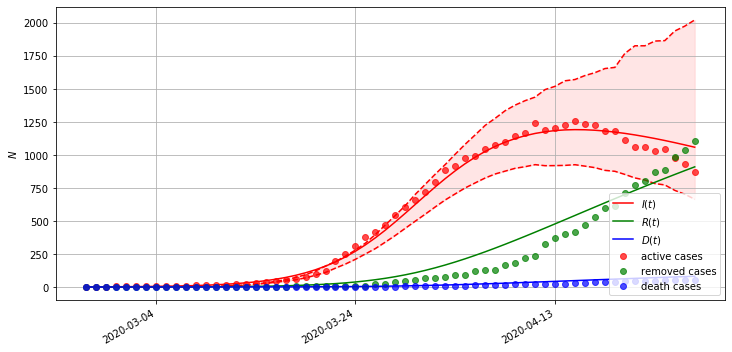

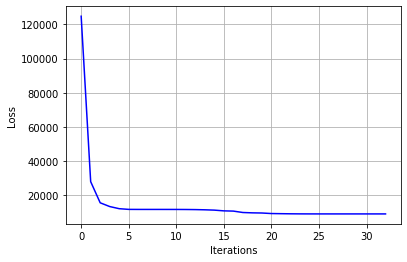

In [4]:
# Simulation for the first bi-month in the first epi wave

S0 = 2200
E0 = 3 * active_cases_1[0]
I0 = active_cases_1[0]
R0 = recovered_cases_1[0]
D0 = death_cases_1[0]

duration = 62 # in days
(S, E, I, R, D), loss = simulate_SEIRD(
    active_cases=active_cases_1[:duration], 
    recovered_cases=recovered_cases_1[:duration], 
    death_cases=death_cases_1[:duration],
    initial_conditions=(S0, E0, I0, R0, D0),
    epidemics_start_date=start_date_1,
    plot_sim=True,
    plot_l=True,
    sensitivity=0.90,
    specificity=0.96,
    new_positives=np.diff(np.concatenate((np.array([0]), confirmed_cases_1[:duration]))),
    total_tests=tests_1[:duration],
)